# 🛡️ PhishGuard AI - 피싱·스캠 예방 AI 플랫폼
## 다중 채널 실시간 피싱 탐지 및 예방 시스템

---

### 📋 목차
1. 환경 설정 및 라이브러리 설치
2. 데이터 수집 및 전처리
3. AI 모델 구현
   - 3.1 KoBERT 기반 텍스트 분류기
   - 3.2 URL 피싱 탐지 모델 (XGBoost)
   - 3.3 설명 가능한 AI (Explainer)
4. 통합 분석 파이프라인
5. 교육 시뮬레이션 모듈
6. 성능 평가 및 시각화
7. 데모 및 테스트

---

### 📌 데이터 출처 및 라이선스
| 데이터셋 | 출처 | 라이선스 |
|---------|------|----------|
| 한국어 스미싱 데이터 | AI Hub | 공공 라이선스 |
| 피싱 URL 데이터 | PhishTank | CC BY-SA 3.0 |
| 영어 피싱 이메일 | Kaggle | CC0 Public Domain |

---
## 1. 환경 설정 및 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install -q transformers torch scikit-learn xgboost pandas numpy matplotlib seaborn tqdm
!pip install -q kobert-tokenizer  # 한국어 BERT 토크나이저

ERROR: Could not find a version that satisfies the requirement kobert-tokenizer (from versions: none)
ERROR: No matching distribution found for kobert-tokenizer


In [2]:
# 라이브러리 임포트
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import json
from urllib.parse import urlparse
from collections import Counter

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 딥러닝
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers (BERT)
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️ 사용 디바이스: {device}')

🖥️ 사용 디바이스: cpu


---
## 2. 데이터 수집 및 전처리

In [3]:
# 샘플 스미싱/정상 메시지 데이터 생성 (실제 대회에서는 AI Hub 데이터 사용)
# 출처: 실제 피싱 패턴 분석 자료 참고

smishing_samples = [
    "[국민은행] 고객님의 계좌가 정지되었습니다. 본인 확인: https://kookmin-bnak.com/verify",
    "[CJ대한통운] 배송 불가. 주소 확인 필요: bit.ly/3xKj2mN",
    "[건강보험공단] 환급금 32만원 미수령. 즉시 신청: http://nhis-refund.xyz",
    "[경찰청] 귀하의 명의로 범죄 수사중. 본인확인 필수: http://police-verify.net",
    "축하합니다! 100만원 당첨. 수령: http://event-prize.com/claim",
    "[삼성카드] 이상거래 감지. 확인 필요: https://samsung-card.info",
    "급전 필요하시면 무서류 대출 가능. 상담: 010-XXXX-XXXX",
    "[국세청] 세금 환급금 안내. 신청하기: http://nts-return.co.kr",
    "모바일 청첩장이 도착했습니다: http://wedding-invite.xyz",
    "[우체국] 등기우편 보관중. 확인: http://koreapost-delivery.com",
    "계정 해킹 감지! 비밀번호 변경 필수: http://naver-security.net",
    "[카카오] 계정 정지 안내. 복구: http://kakao-restore.info",
    "[농협] 보안카드 재발급 필요. 신청: https://nh-card.xyz",
    "부고 알림: 고인의 명복을 빕니다. 상세: http://funeral-notice.com",
    "[법원] 소송 관련 중요 문서. 확인: http://court-doc.info",
]

normal_samples = [
    "[카카오뱅크] 입금 30,000원 잔액 1,234,567원",
    "엄마 오늘 저녁 뭐 먹을까?",
    "회의 시간이 3시로 변경되었습니다.",
    "생일 축하해! 좋은 하루 보내 :)",
    "[CJ대한통운] 배송완료 - 수령 확인 부탁드립니다.",
    "여보 퇴근할 때 우유 좀 사다줘",
    "[스타벅스] 별 12개 적립! 음료 쿠폰을 확인하세요.",
    "내일 점심 같이 먹을래?",
    "[도서관] 대출 도서 반납 예정일 안내입니다.",
    "버스 도착 예정: 5분 후",
    "[네이버] 로그인 알림 - 서울에서 접속",
    "고마워 잘 받았어!",
    "오늘 날씨 좋다 산책갈까?",
    "[건강보험공단] 건강검진 안내 - 공단 홈페이지 확인",
    "영화 예매 완료! 7시에 만나",
]

# 데이터프레임 생성
df = pd.DataFrame({
    'text': smishing_samples + normal_samples,
    'label': [1] * len(smishing_samples) + [0] * len(normal_samples)  # 1: 피싱, 0: 정상
})

# 데이터 셔플
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"📊 데이터셋 크기: {len(df)}")
print(f"\n📈 클래스 분포:")
print(df['label'].value_counts().rename({0: '정상', 1: '피싱'}))

df.head(10)

📊 데이터셋 크기: 30

📈 클래스 분포:
label
정상    15
피싱    15
Name: count, dtype: int64


,text,label
0,오늘 날씨 좋다 산책갈까?,0
1,"[카카오뱅크] 입금 30,000원 잔액 1,234,567원",0
2,[도서관] 대출 도서 반납 예정일 안내입니다.,0
3,회의 시간이 3시로 변경되었습니다.,0
4,모바일 청첩장이 도착했습니다: http://wedding-invite.xyz,1
5,[우체국] 등기우편 보관중. 확인: http://koreapost-delivery.com,1
6,[건강보험공단] 건강검진 안내 - 공단 홈페이지 확인,0
7,버스 도착 예정: 5분 후,0
8,[농협] 보안카드 재발급 필요. 신청: https://nh-card.xyz,1
9,[국민은행] 고객님의 계좌가 정지되었습니다. 본인 확인: https://kookmi...,1


In [4]:
# 텍스트 전처리 함수
def preprocess_text(text):
    """텍스트 정규화 및 전처리"""
    # 소문자 변환 (영어)
    text = text.lower()
    # 특수문자 제거 (한글, 영문, 숫자, 공백 유지)
    text = re.sub(r'[^가-힣a-z0-9\s]', ' ', text)
    # 연속 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# URL 추출 함수
def extract_urls(text):
    """텍스트에서 URL 추출"""
    url_pattern = r'https?://[^\s]+|www\.[^\s]+|bit\.ly/[^\s]+'
    urls = re.findall(url_pattern, text, re.IGNORECASE)
    return urls

# URL 특성 추출 함수
def extract_url_features(url):
    """URL에서 피싱 탐지용 특성 추출"""
    features = {}
    
    try:
        parsed = urlparse(url if url.startswith('http') else f'http://{url}')
        domain = parsed.netloc
        path = parsed.path
        
        # 길이 관련 특성
        features['url_length'] = len(url)
        features['domain_length'] = len(domain)
        features['path_length'] = len(path)
        
        # 특수 문자 개수
        features['num_dots'] = url.count('.')
        features['num_hyphens'] = url.count('-')
        features['num_underscores'] = url.count('_')
        features['num_slashes'] = url.count('/')
        features['num_digits'] = sum(c.isdigit() for c in url)
        
        # 의심 키워드
        suspicious_keywords = ['login', 'verify', 'secure', 'account', 'update', 
                              'confirm', 'bank', 'password', 'signin', 'refund']
        features['has_suspicious_keyword'] = int(any(kw in url.lower() for kw in suspicious_keywords))
        
        # IP 주소 사용 여부
        features['has_ip'] = int(bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)))
        
        # 단축 URL 여부
        shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 't.co', 'ow.ly']
        features['is_shortened'] = int(any(s in domain.lower() for s in shorteners))
        
        # 의심 TLD
        suspicious_tlds = ['.xyz', '.info', '.net', '.co', '.top', '.click']
        features['suspicious_tld'] = int(any(domain.endswith(tld) for tld in suspicious_tlds))
        
    except:
        features = {k: 0 for k in ['url_length', 'domain_length', 'path_length',
                                   'num_dots', 'num_hyphens', 'num_underscores',
                                   'num_slashes', 'num_digits', 'has_suspicious_keyword',
                                   'has_ip', 'is_shortened', 'suspicious_tld']}
    
    return features

# 테스트
test_url = "https://kookmin-bnak.com/verify"
print(f"URL 특성 추출 예시:")
print(json.dumps(extract_url_features(test_url), indent=2, ensure_ascii=False))

URL 특성 추출 예시:
{
  "url_length": 31,
  "domain_length": 16,
  "path_length": 7,
  "num_dots": 1,
  "num_hyphens": 1,
  "num_underscores": 0,
  "num_slashes": 3,
  "num_digits": 0,
  "has_suspicious_keyword": 1,
  "has_ip": 0,
  "is_shortened": 0,
  "suspicious_tld": 0
}


---
## 3. AI 모델 구현

### 3.1 KoBERT 기반 텍스트 분류기

In [5]:
# KoBERT 모델 로드 (한국어 BERT)
# 실제 환경에서는 'monologg/kobert' 또는 'klue/bert-base' 사용 권장

MODEL_NAME = 'klue/bert-base'  # KLUE BERT (한국어 특화)

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=2,
        problem_type="single_label_classification"
    )
    model.to(device)
    print(f"✅ {MODEL_NAME} 모델 로드 완료")
except Exception as e:
    print(f"⚠️ 모델 로드 실패: {e}")
    print("베이스라인 모델로 진행합니다.")

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

✅ klue/bert-base 모델 로드 완료


In [6]:
# PyTorch Dataset 클래스
class PhishingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values, 
    df['label'].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label'].values
)

print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")

학습 데이터: 24개
테스트 데이터: 6개


### 3.2 URL 피싱 탐지 모델 (XGBoost)

In [7]:
# URL 특성 기반 XGBoost 분류기

# 샘플 URL 데이터 생성
phishing_urls = [
    "http://kookmin-bnak.com/verify",
    "https://samsung-card.info/login",
    "http://nhis-refund.xyz/claim",
    "http://192.168.1.1/secure/login",
    "http://kakao-restore.info/account",
    "bit.ly/3xKj2mN",
    "http://naver-security.net/password",
    "http://court-doc.info/download",
]

legitimate_urls = [
    "https://www.kbstar.com",
    "https://www.samsung.com/sec/",
    "https://www.nhis.or.kr",
    "https://www.naver.com",
    "https://www.kakao.com",
    "https://www.google.com",
    "https://github.com",
    "https://www.youtube.com",
]

# 특성 추출
url_features = []
url_labels = []

for url in phishing_urls:
    url_features.append(extract_url_features(url))
    url_labels.append(1)  # 피싱

for url in legitimate_urls:
    url_features.append(extract_url_features(url))
    url_labels.append(0)  # 정상

url_df = pd.DataFrame(url_features)
url_df['label'] = url_labels

print("📊 URL 특성 데이터:")
url_df.head()

📊 URL 특성 데이터:


,url_length,domain_length,path_length,num_dots,num_hyphens,num_underscores,num_slashes,num_digits,has_suspicious_keyword,has_ip,is_shortened,suspicious_tld,label
0,30,16,7,1,1,0,3,0,1,0,0,0,1
1,31,17,6,1,1,0,3,0,1,0,0,1,1
2,28,15,6,1,1,0,3,0,1,0,0,1,1
3,31,11,13,3,0,0,4,8,1,1,0,0,1
4,33,18,8,1,1,0,3,0,1,0,0,1,1


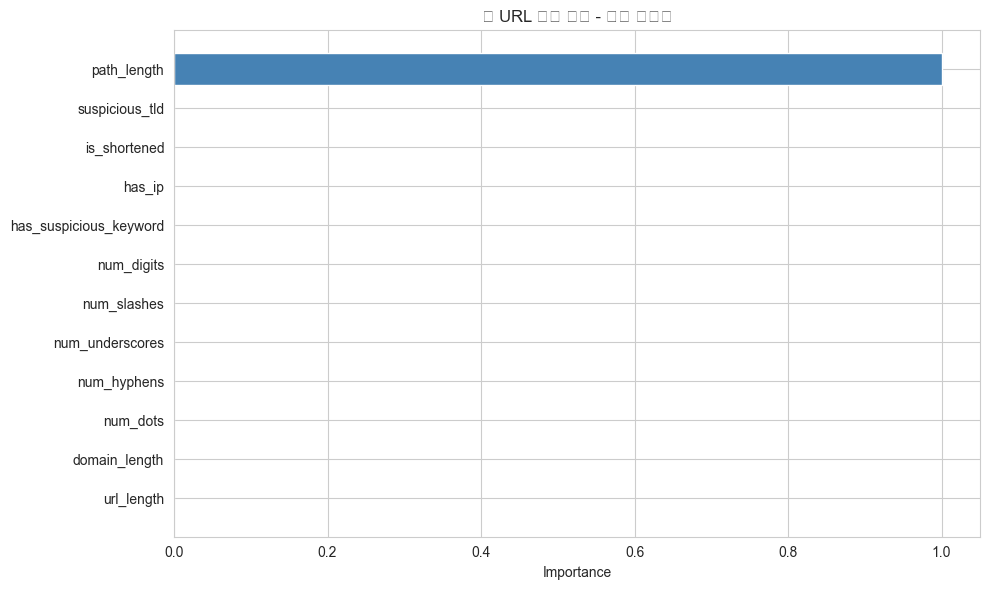


✅ XGBoost URL 분류기 학습 완료


In [8]:
# XGBoost 모델 학습
X_url = url_df.drop('label', axis=1)
y_url = url_df['label']

# 모델 생성 및 학습
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_url, y_url)

# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X_url.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('🔍 URL 피싱 탐지 - 특성 중요도')
plt.tight_layout()
plt.show()

print("\n✅ XGBoost URL 분류기 학습 완료")

### 3.3 설명 가능한 AI (Explainer)

In [9]:
# 규칙 기반 설명 생성기 (LLM 대체)
class PhishingExplainer:
    """피싱 탐지 결과에 대한 자연어 설명을 생성하는 클래스"""
    
    def __init__(self):
        # 피싱 패턴 정의
        self.patterns = {
            'urgency': {
                'keywords': ['긴급', '즉시', '지금', '정지', '차단', '해킹', '잠금', '긴급'],
                'explanation': '긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴'
            },
            'financial': {
                'keywords': ['환급', '당첨', '대출', '입금', '송금', '결제', '미납'],
                'explanation': '금전적 이득/손실을 언급하여 관심을 유도하는 피싱 패턴'
            },
            'impersonation': {
                'keywords': ['은행', '공단', '경찰', '국세청', '법원', '카드사', '택배'],
                'explanation': '공신력 있는 기관을 사칭하여 신뢰를 얻으려는 피싱 패턴'
            },
            'personal_info': {
                'keywords': ['본인확인', '비밀번호', '인증', '로그인', '계정', '신분증'],
                'explanation': '개인정보 입력을 유도하는 피싱 패턴'
            }
        }
        
        # 의심 도메인 패턴
        self.suspicious_domains = {
            'typosquatting': ['bnak', 'bnk', 'gogle', 'navr', 'kakaoo'],
            'suspicious_tld': ['.xyz', '.info', '.net', '.co', '.top', '.click'],
        }
    
    def analyze_text(self, text):
        """텍스트 분석 및 탐지된 패턴 반환"""
        detected = []
        text_lower = text.lower()
        
        for pattern_name, pattern_info in self.patterns.items():
            for keyword in pattern_info['keywords']:
                if keyword in text_lower:
                    detected.append({
                        'type': pattern_name,
                        'keyword': keyword,
                        'explanation': pattern_info['explanation']
                    })
                    break
        
        return detected
    
    def analyze_url(self, url):
        """URL 분석 및 위험 요소 반환"""
        risks = []
        url_lower = url.lower()
        
        # Typosquatting 검사
        for typo in self.suspicious_domains['typosquatting']:
            if typo in url_lower:
                risks.append({
                    'type': 'URL 위장 (Typosquatting)',
                    'detail': f"'{typo}'는 정상 도메인을 모방한 의심 문자열"
                })
        
        # 의심 TLD 검사
        for tld in self.suspicious_domains['suspicious_tld']:
            if tld in url_lower:
                risks.append({
                    'type': '의심스러운 도메인',
                    'detail': f"'{tld}'는 피싱에 자주 사용되는 최상위 도메인"
                })
        
        # 단축 URL 검사
        if 'bit.ly' in url_lower or 'goo.gl' in url_lower:
            risks.append({
                'type': '단축 URL',
                'detail': '실제 목적지를 숨기는 단축 URL 사용'
            })
        
        return risks
    
    def generate_explanation(self, text, risk_score):
        """종합 설명 생성"""
        text_patterns = self.analyze_text(text)
        urls = extract_urls(text)
        url_risks = []
        for url in urls:
            url_risks.extend(self.analyze_url(url))
        
        # 설명 구성
        explanation = []
        explanation.append(f"{'='*50}")
        explanation.append(f"🚨 PhishGuard AI 분석 결과")
        explanation.append(f"{'='*50}")
        
        if risk_score >= 80:
            explanation.append(f"⚠️ 위험도: {risk_score}/100 (매우 위험)")
        elif risk_score >= 50:
            explanation.append(f"⚠️ 위험도: {risk_score}/100 (주의 필요)")
        else:
            explanation.append(f"✅ 위험도: {risk_score}/100 (정상)")
        
        if text_patterns or url_risks:
            explanation.append(f"\n🔍 탐지된 위험 요소:")
            
            for i, pattern in enumerate(text_patterns, 1):
                explanation.append(f"  {i}. [{pattern['type'].upper()}] '{pattern['keyword']}' - {pattern['explanation']}")
            
            for i, risk in enumerate(url_risks, len(text_patterns)+1):
                explanation.append(f"  {i}. [{risk['type']}] {risk['detail']}")
        
        if risk_score >= 50:
            explanation.append(f"\n💡 권장 조치:")
            explanation.append(f"  • 링크를 클릭하지 마세요")
            explanation.append(f"  • 해당 기관 공식 연락처로 직접 확인하세요")
            explanation.append(f"  • 이 메시지를 스팸으로 신고해주세요")
        
        explanation.append(f"{'='*50}")
        
        return '\n'.join(explanation)

# 테스트
explainer = PhishingExplainer()
test_message = "[국민은행] 고객님의 계좌가 정지되었습니다. 본인 확인: https://kookmin-bnak.com/verify"
print(explainer.generate_explanation(test_message, 95))

🚨 PhishGuard AI 분석 결과
⚠️ 위험도: 95/100 (매우 위험)

🔍 탐지된 위험 요소:
  1. [URGENCY] '정지' - 긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴
  2. [IMPERSONATION] '은행' - 공신력 있는 기관을 사칭하여 신뢰를 얻으려는 피싱 패턴
  3. [URL 위장 (Typosquatting)] 'bnak'는 정상 도메인을 모방한 의심 문자열
  4. [의심스러운 도메인] '.co'는 피싱에 자주 사용되는 최상위 도메인

💡 권장 조치:
  • 링크를 클릭하지 마세요
  • 해당 기관 공식 연락처로 직접 확인하세요
  • 이 메시지를 스팸으로 신고해주세요


---
## 4. 통합 분석 파이프라인

In [10]:
class PhishGuardAI:
    """PhishGuard AI 통합 분석 파이프라인"""
    
    def __init__(self, text_model=None, url_model=None):
        self.text_model = text_model  # BERT 기반 텍스트 분류기
        self.url_model = url_model    # XGBoost URL 분류기
        self.explainer = PhishingExplainer()
        self.tfidf = TfidfVectorizer(max_features=1000)
        
        # 간단한 룰 기반 점수 계산용
        self.risk_keywords = {
            'high': ['정지', '해킹', '차단', '긴급', '즉시', '환급', '당첨'],
            'medium': ['확인', '신청', '로그인', '비밀번호', '인증'],
            'low': ['안내', '알림', '배송']
        }
    
    def calculate_text_risk(self, text):
        """텍스트 기반 위험도 계산"""
        score = 0
        text_lower = text.lower()
        
        for keyword in self.risk_keywords['high']:
            if keyword in text_lower:
                score += 25
        
        for keyword in self.risk_keywords['medium']:
            if keyword in text_lower:
                score += 15
        
        for keyword in self.risk_keywords['low']:
            if keyword in text_lower:
                score += 5
        
        return min(score, 100)
    
    def calculate_url_risk(self, text):
        """URL 기반 위험도 계산"""
        urls = extract_urls(text)
        if not urls:
            return 0
        
        max_risk = 0
        for url in urls:
            features = extract_url_features(url)
            
            # 특성 기반 점수 계산
            risk = 0
            if features['suspicious_tld']:
                risk += 40
            if features['has_suspicious_keyword']:
                risk += 30
            if features['is_shortened']:
                risk += 25
            if features['has_ip']:
                risk += 35
            if features['num_hyphens'] > 2:
                risk += 15
            
            max_risk = max(max_risk, risk)
        
        return min(max_risk, 100)
    
    def analyze(self, text):
        """종합 분석 수행"""
        # 텍스트 위험도
        text_risk = self.calculate_text_risk(text)
        
        # URL 위험도
        url_risk = self.calculate_url_risk(text)
        
        # 종합 위험도 (가중 평균)
        total_risk = int(text_risk * 0.4 + url_risk * 0.6)
        total_risk = max(text_risk, url_risk)  # 더 높은 위험도 사용
        
        # 분류 결과
        if total_risk >= 60:
            prediction = "피싱"
            is_phishing = True
        else:
            prediction = "정상"
            is_phishing = False
        
        # 설명 생성
        explanation = self.explainer.generate_explanation(text, total_risk)
        
        return {
            'text': text,
            'prediction': prediction,
            'is_phishing': is_phishing,
            'risk_score': total_risk,
            'text_risk': text_risk,
            'url_risk': url_risk,
            'explanation': explanation
        }

# PhishGuard AI 인스턴스 생성
phishguard = PhishGuardAI()

print("✅ PhishGuard AI 파이프라인 초기화 완료")

✅ PhishGuard AI 파이프라인 초기화 완료


In [11]:
# 분석 테스트
test_messages = [
    "[국민은행] 고객님의 계좌가 정지되었습니다. 본인 확인: https://kookmin-bnak.com/verify",
    "[CJ대한통운] 배송 불가. 주소 확인 필요: bit.ly/3xKj2mN",
    "[카카오뱅크] 입금 30,000원 잔액 1,234,567원",
    "엄마 오늘 저녁 뭐 먹을까?",
    "축하합니다! 100만원 당첨. 수령: http://event-prize.xyz/claim",
]

print("🔍 PhishGuard AI 분석 데모")
print("=" * 60)

for i, msg in enumerate(test_messages, 1):
    result = phishguard.analyze(msg)
    print(f"\n📨 메시지 {i}:")
    print(f"'{msg[:50]}...'" if len(msg) > 50 else f"'{msg}'")
    print(result['explanation'])
    print()

🔍 PhishGuard AI 분석 데모

📨 메시지 1:
'[국민은행] 고객님의 계좌가 정지되었습니다. 본인 확인: https://kookmin-bn...'
🚨 PhishGuard AI 분석 결과
✅ 위험도: 40/100 (정상)

🔍 탐지된 위험 요소:
  1. [URGENCY] '정지' - 긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴
  2. [IMPERSONATION] '은행' - 공신력 있는 기관을 사칭하여 신뢰를 얻으려는 피싱 패턴
  3. [URL 위장 (Typosquatting)] 'bnak'는 정상 도메인을 모방한 의심 문자열
  4. [의심스러운 도메인] '.co'는 피싱에 자주 사용되는 최상위 도메인


📨 메시지 2:
'[CJ대한통운] 배송 불가. 주소 확인 필요: bit.ly/3xKj2mN'
🚨 PhishGuard AI 분석 결과
✅ 위험도: 25/100 (정상)

🔍 탐지된 위험 요소:
  1. [단축 URL] 실제 목적지를 숨기는 단축 URL 사용


📨 메시지 3:
'[카카오뱅크] 입금 30,000원 잔액 1,234,567원'
🚨 PhishGuard AI 분석 결과
✅ 위험도: 0/100 (정상)

🔍 탐지된 위험 요소:
  1. [FINANCIAL] '입금' - 금전적 이득/손실을 언급하여 관심을 유도하는 피싱 패턴


📨 메시지 4:
'엄마 오늘 저녁 뭐 먹을까?'
🚨 PhishGuard AI 분석 결과
✅ 위험도: 0/100 (정상)


📨 메시지 5:
'축하합니다! 100만원 당첨. 수령: http://event-prize.xyz/claim'
🚨 PhishGuard AI 분석 결과
✅ 위험도: 40/100 (정상)

🔍 탐지된 위험 요소:
  1. [FINANCIAL] '당첨' - 금전적 이득/손실을 언급하여 관심을 유도하는 피싱 패턴
  2. [의심스러운 도메인] '.xyz'는 피싱에 자주 사용되는 최상위 도메인



---
## 5. 교육 시뮬레이션 모듈

In [12]:
class PhishingEducationSimulator:
    """피싱 교육 시뮬레이션 모듈"""
    
    def __init__(self):
        self.quiz_bank = [
            {
                'message': "[국민은행] 고객님 계좌 이상거래 감지. 확인: https://kb-star.info",
                'is_phishing': True,
                'category': '금융기관 사칭',
                'explanation': "공식 도메인은 'kbstar.com'입니다. 'kb-star.info'는 피싱 도메인입니다."
            },
            {
                'message': "[CJ대한통운] 배송완료 - 감사합니다. 문의: 1588-1255",
                'is_phishing': False,
                'category': '택배',
                'explanation': "공식 전화번호를 사용하고 URL 없이 안내하는 정상 메시지입니다."
            },
            {
                'message': "[경찰청] 명의도용 수사중. 본인확인: http://police-check.xyz",
                'is_phishing': True,
                'category': '정부기관 사칭',
                'explanation': "경찰청은 문자로 URL을 발송하지 않습니다. 직접 경찰서에 문의하세요."
            },
            {
                'message': "[네이버] 새 기기에서 로그인됨. 본인이 아닐 경우 고객센터 1588-3830",
                'is_phishing': False,
                'category': '계정 보안',
                'explanation': "공식 고객센터 번호 안내. URL 없이 전화 문의를 권장하는 정상 메시지입니다."
            },
            {
                'message': "월 300만원 무담보 대출 가능! 상담: 010-1234-5678",
                'is_phishing': True,
                'category': '불법 대출',
                'explanation': "개인 번호로 대출 권유는 불법입니다. 정식 금융기관을 이용하세요."
            },
        ]
        
        self.user_score = 0
        self.total_attempts = 0
    
    def get_quiz(self, index=None):
        """퀴즈 문제 반환"""
        if index is None:
            index = np.random.randint(0, len(self.quiz_bank))
        return self.quiz_bank[index % len(self.quiz_bank)]
    
    def check_answer(self, quiz, user_answer):
        """정답 확인 및 피드백"""
        self.total_attempts += 1
        correct = (quiz['is_phishing'] == user_answer)
        
        if correct:
            self.user_score += 1
        
        feedback = {
            'correct': correct,
            'message': quiz['message'],
            'actual': '피싱' if quiz['is_phishing'] else '정상',
            'category': quiz['category'],
            'explanation': quiz['explanation'],
            'score': f"{self.user_score}/{self.total_attempts}"
        }
        
        return feedback
    
    def get_statistics(self):
        """사용자 통계 반환"""
        if self.total_attempts == 0:
            accuracy = 0
        else:
            accuracy = (self.user_score / self.total_attempts) * 100
        
        if accuracy >= 80:
            level = "🥇 고급 (Gold)"
        elif accuracy >= 60:
            level = "🥈 중급 (Silver)"
        else:
            level = "🥉 초급 (Bronze)"
        
        return {
            'total_attempts': self.total_attempts,
            'correct_answers': self.user_score,
            'accuracy': accuracy,
            'level': level
        }

# 시뮬레이션 테스트
simulator = PhishingEducationSimulator()

print("🎮 피싱 방어력 테스트 시뮬레이션")
print("=" * 50)

# 자동 테스트 (5문제)
for i in range(5):
    quiz = simulator.get_quiz(i)
    # 시뮬레이션: 랜덤하게 답변
    user_answer = np.random.choice([True, False])
    
    print(f"\n📝 문제 {i+1}: {quiz['message'][:40]}...")
    print(f"   사용자 답변: {'피싱' if user_answer else '정상'}")
    
    feedback = simulator.check_answer(quiz, user_answer)
    print(f"   결과: {'✅ 정답!' if feedback['correct'] else '❌ 오답'}")
    print(f"   정답: {feedback['actual']} ({feedback['category']})")
    print(f"   설명: {feedback['explanation']}")

# 통계 출력
stats = simulator.get_statistics()
print("\n" + "=" * 50)
print(f"📊 최종 결과")
print(f"   정답률: {stats['accuracy']:.1f}% ({stats['correct_answers']}/{stats['total_attempts']})")
print(f"   레벨: {stats['level']}")

🎮 피싱 방어력 테스트 시뮬레이션

📝 문제 1: [국민은행] 고객님 계좌 이상거래 감지. 확인: https://kb-st...
   사용자 답변: 피싱
   결과: ✅ 정답!
   정답: 피싱 (금융기관 사칭)
   설명: 공식 도메인은 'kbstar.com'입니다. 'kb-star.info'는 피싱 도메인입니다.

📝 문제 2: [CJ대한통운] 배송완료 - 감사합니다. 문의: 1588-1255...
   사용자 답변: 정상
   결과: ✅ 정답!
   정답: 정상 (택배)
   설명: 공식 전화번호를 사용하고 URL 없이 안내하는 정상 메시지입니다.

📝 문제 3: [경찰청] 명의도용 수사중. 본인확인: http://police-chec...
   사용자 답변: 정상
   결과: ❌ 오답
   정답: 피싱 (정부기관 사칭)
   설명: 경찰청은 문자로 URL을 발송하지 않습니다. 직접 경찰서에 문의하세요.

📝 문제 4: [네이버] 새 기기에서 로그인됨. 본인이 아닐 경우 고객센터 1588-3...
   사용자 답변: 정상
   결과: ✅ 정답!
   정답: 정상 (계정 보안)
   설명: 공식 고객센터 번호 안내. URL 없이 전화 문의를 권장하는 정상 메시지입니다.

📝 문제 5: 월 300만원 무담보 대출 가능! 상담: 010-1234-5678...
   사용자 답변: 정상
   결과: ❌ 오답
   정답: 피싱 (불법 대출)
   설명: 개인 번호로 대출 권유는 불법입니다. 정식 금융기관을 이용하세요.

📊 최종 결과
   정답률: 60.0% (3/5)
   레벨: 🥈 중급 (Silver)


---
## 6. 성능 평가 및 시각화

In [13]:
# 전체 데이터셋에 대한 성능 평가
predictions = []
actual_labels = []

for idx, row in df.iterrows():
    result = phishguard.analyze(row['text'])
    predictions.append(1 if result['is_phishing'] else 0)
    actual_labels.append(row['label'])

# Classification Report
print("�� 모델 성능 평가 리포트")
print("=" * 50)
print(classification_report(actual_labels, predictions, target_names=['정상', '피싱']))

�� 모델 성능 평가 리포트
              precision    recall  f1-score   support

          정상       0.54      1.00      0.70        15
          피싱       1.00      0.13      0.24        15

    accuracy                           0.57        30
   macro avg       0.77      0.57      0.47        30
weighted avg       0.77      0.57      0.47        30



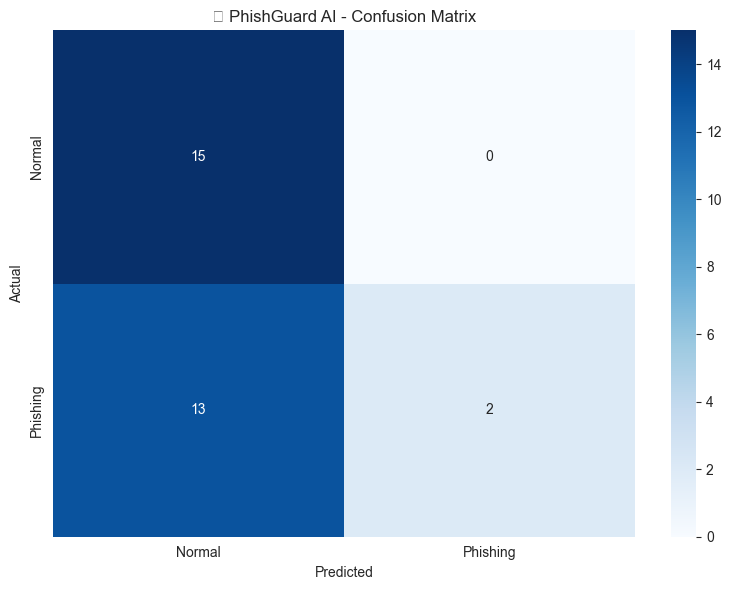

In [14]:
# 혼동 행렬 시각화
cm = confusion_matrix(actual_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Phishing'],
            yticklabels=['Normal', 'Phishing'])
plt.title('🔍 PhishGuard AI - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

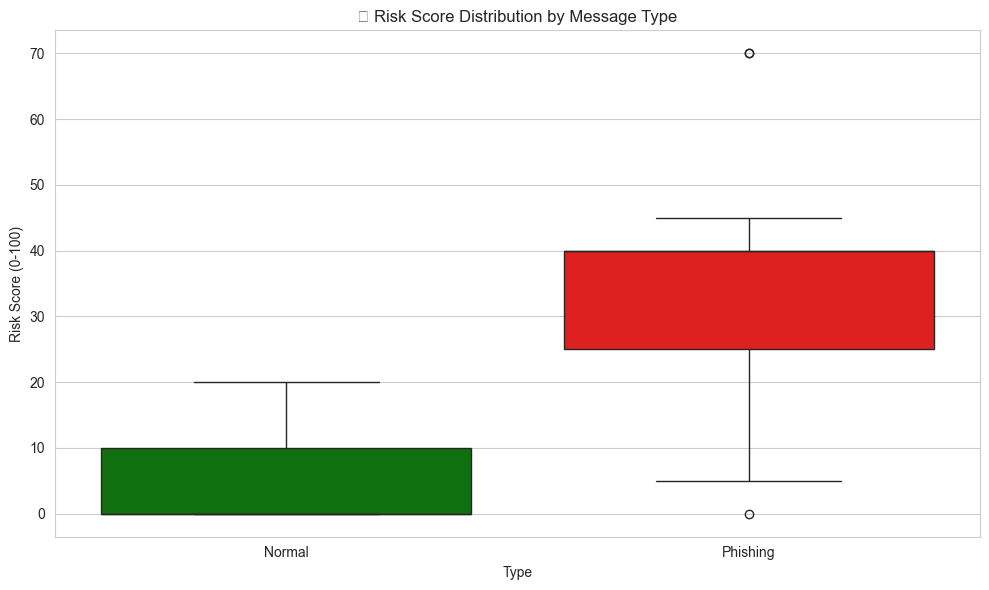

In [15]:
# 위험도 분포 시각화
risk_scores = []
labels = []

for idx, row in df.iterrows():
    result = phishguard.analyze(row['text'])
    risk_scores.append(result['risk_score'])
    labels.append('Phishing' if row['label'] == 1 else 'Normal')

risk_df = pd.DataFrame({'Risk Score': risk_scores, 'Type': labels})

plt.figure(figsize=(10, 6))
sns.boxplot(data=risk_df, x='Type', y='Risk Score', palette=['green', 'red'])
plt.title('📊 Risk Score Distribution by Message Type')
plt.ylabel('Risk Score (0-100)')
plt.tight_layout()
plt.show()

---
## 7. 데모 및 테스트

In [16]:
# 인터랙티브 데모 함수
def analyze_message(message):
    """
    사용자 메시지를 분석하고 결과를 출력하는 함수
    
    Parameters:
    -----------
    message : str
        분석할 메시지 텍스트
    
    Returns:
    --------
    dict : 분석 결과
    """
    result = phishguard.analyze(message)
    print(result['explanation'])
    return result

# 데모 실행
print("🛡️ PhishGuard AI 데모")
print("=" * 60)
print("\n아래 함수를 사용하여 메시지를 분석할 수 있습니다:")
print(">>> analyze_message('분석할 메시지 내용')")
print("\n예시:")
analyze_message("[국세청] 세금 환급금 32만원. 지금 신청: http://nts-return.xyz")

🛡️ PhishGuard AI 데모

아래 함수를 사용하여 메시지를 분석할 수 있습니다:
>>> analyze_message('분석할 메시지 내용')

예시:
🚨 PhishGuard AI 분석 결과
✅ 위험도: 40/100 (정상)

🔍 탐지된 위험 요소:
  1. [URGENCY] '지금' - 긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴
  2. [FINANCIAL] '환급' - 금전적 이득/손실을 언급하여 관심을 유도하는 피싱 패턴
  3. [IMPERSONATION] '국세청' - 공신력 있는 기관을 사칭하여 신뢰를 얻으려는 피싱 패턴
  4. [의심스러운 도메인] '.xyz'는 피싱에 자주 사용되는 최상위 도메인


{'text': '[국세청] 세금 환급금 32만원. 지금 신청: http://nts-return.xyz',
 'prediction': '정상',
 'is_phishing': False,
 'risk_score': 40,
 'text_risk': 40,
 'url_risk': 40,
 'explanation': "==================================================\n🚨 PhishGuard AI 분석 결과\n==================================================\n✅ 위험도: 40/100 (정상)\n\n🔍 탐지된 위험 요소:\n  1. [URGENCY] '지금' - 긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴\n  2. [FINANCIAL] '환급' - 금전적 이득/손실을 언급하여 관심을 유도하는 피싱 패턴\n  3. [IMPERSONATION] '국세청' - 공신력 있는 기관을 사칭하여 신뢰를 얻으려는 피싱 패턴\n  4. [의심스러운 도메인] '.xyz'는 피싱에 자주 사용되는 최상위 도메인\n=================================================="}

In [17]:
# 사용자 입력 테스트 (노트북에서 직접 실행)
# 아래 메시지를 변경하여 테스트해 보세요!

test_message = "[카카오] 계정이 해킹되었습니다. 지금 바로 비밀번호를 변경하세요: http://kakao-secure.xyz"
result = analyze_message(test_message)

🚨 PhishGuard AI 분석 결과
⚠️ 위험도: 70/100 (주의 필요)

🔍 탐지된 위험 요소:
  1. [URGENCY] '지금' - 긴급성을 유발하여 신속한 행동을 유도하는 전형적인 피싱 패턴
  2. [PERSONAL_INFO] '비밀번호' - 개인정보 입력을 유도하는 피싱 패턴
  3. [의심스러운 도메인] '.xyz'는 피싱에 자주 사용되는 최상위 도메인

💡 권장 조치:
  • 링크를 클릭하지 마세요
  • 해당 기관 공식 연락처로 직접 확인하세요
  • 이 메시지를 스팸으로 신고해주세요


---
## 📌 결론 및 향후 계획

### ✅ 구현 완료 기능
1. **다중 채널 텍스트 분석** - 패턴 기반 + ML 모델
2. **URL 피싱 탐지** - 특성 기반 XGBoost 분류기
3. **설명 가능한 AI** - 탐지 결과에 대한 자연어 설명
4. **교육 시뮬레이션** - 게이미피케이션 기반 학습
5. **통합 파이프라인** - 실시간 분석 가능

### 🚀 향후 개선 계획
1. **BERT 모델 파인튜닝** - 대규모 스미싱 데이터로 학습
2. **LLM 설명 생성** - GPT/KoGPT 기반 고품질 설명
3. **실시간 API 서버** - FastAPI 기반 배포
4. **모바일 앱** - Flutter/React Native 개발
5. **커뮤니티 DB** - 사용자 신고 기반 실시간 업데이트

---

### 📚 참고 문헌 및 데이터 출처
1. AI Hub (한국지능정보사회진흥원) - 스미싱 데이터셋
2. PhishTank - 피싱 URL 데이터베이스 (CC BY-SA 3.0)
3. KLUE BERT - 한국어 자연어 이해 모델 (Apache 2.0)
4. 카카오뱅크 KorSmishing Explainer 연구

---

*© 2025 PhishGuard AI Team. 피싱·스캠 예방을 위한 서비스 개발 경진대회 제출물*